In [1]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import torch.nn as nn
import torch


from torch.utils.data import DataLoader
from torchmetrics.classification import BinaryAccuracy, AUROC, F1Score, BinaryROC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from lnn_model_hdf5 import JetParticleDataset, BinaryClassificationLTC
from utils import count_parameters, plot_metrics, plot_ROC

from time import time
import gc

In [2]:
print('Preparing data...')
start = time()
        

checkpoint_path = '/home/asugu/work/part/LNN/checkpoints/model_checkpoint_hdf5_7.pth'

dtype  = 'np.float32'
sample_size  = int(1e+6)

df  = pd.read_hdf(f'/home/asugu/work/part/all_data_{sample_size}.hdf5', key='data', dtype=dtype)   
df = df.astype(np.float32)   

df['pt_cosh']=df['jet_pt']*np.cosh(df['jet_eta'])     # |p|

col_names = df.keys()
target_col_name = "jet_flavor"
input_col_names = [col_name for col_name in col_names if col_name != target_col_name]
df.replace({"inf": 0, "-inf": 0}, inplace=True)


df = df[(np.abs(df-df.mean()) <= 10*df.std()).all(axis=1)]


inputs = df[input_col_names]
labels = df[target_col_name] 
labels = (labels==5).astype(int) #np.array([1 if i == 5 else 0 for i in labels]) 

del df, input_col_names, col_names

gc.collect()

#del event_data
#gc.collect()


Preparing data...


66

In [3]:
from_checkpoint = True

device =  torch.device("cuda:1" if torch.cuda.is_available() else "cpu")  #"mps" if torch.backends.mps.is_available() else "cpu"  

batch_size = 2048
n_epochs = 1
learning_rate = 0.01

in_features = 437
out_features = 1
hidden_units = 24
sparsity = 0.3
N = 64  # Length of the time-series  do i need this

In [4]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(inputs, labels, stratify = labels, test_size = 0.2, shuffle = True, random_state = 42)

del inputs, labels
gc.collect()

scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs  = scaler.transform(val_inputs)

pca_decomposition = PCA()
train_inputs = pca_decomposition.fit_transform(train_inputs)
val_inputs   = pca_decomposition.transform(val_inputs)

train_inputs = torch.tensor(train_inputs,  dtype=torch.float32, device = 'cpu')
train_labels = torch.tensor(train_labels.to_numpy(),  dtype=torch.float32, device = 'cpu').reshape(-1, 1)

val_inputs  = torch.tensor(val_inputs,  dtype=torch.float32, device = device)
val_labels  = torch.tensor(val_labels.to_numpy(),  dtype=torch.float32, device = device).reshape(-1, 1)

#batchsize   = int(len(train_inputs)/10)
train_dataloader = DataLoader(list(zip(train_inputs, train_labels)), batch_size = batch_size , drop_last=True )
test_dataloader = DataLoader(list(zip(val_inputs, val_labels)), batch_size = len(val_inputs) , drop_last=True )

print(len(val_inputs),"test batch size")

finish = time()

print(f'Data preparation has taken {finish-start:.1f} seconds for {len(train_inputs)+len(val_inputs)} rows.')
      

del train_inputs, val_inputs, train_labels, val_labels
gc.collect()


186178 test batch size
Data preparation has taken 30.1 seconds for 930889 rows.


0

In [5]:
#del df, train_df, test_df, train_dataset, test_dataset
#gc.collect()

finish = time()

print(f"Data preperation took {finish-start} seconds.")

Data preperation took 30.75114107131958 seconds.


alloc!
+---------------------------------+------------+
|             Modules             | Parameters |
+---------------------------------+------------+
|     ltc_cell.rnn_cell.gleak     |     24     |
|     ltc_cell.rnn_cell.vleak     |     24     |
|       ltc_cell.rnn_cell.cm      |     24     |
|     ltc_cell.rnn_cell.sigma     |    576     |
|       ltc_cell.rnn_cell.mu      |    576     |
|       ltc_cell.rnn_cell.w       |    576     |
|      ltc_cell.rnn_cell.erev     |    576     |
| ltc_cell.rnn_cell.sensory_sigma |   10488    |
|   ltc_cell.rnn_cell.sensory_mu  |   10488    |
|   ltc_cell.rnn_cell.sensory_w   |   10488    |
|  ltc_cell.rnn_cell.sensory_erev |   10488    |
|    ltc_cell.rnn_cell.input_w    |    437     |
|    ltc_cell.rnn_cell.input_b    |    437     |
|    ltc_cell.rnn_cell.output_w   |     1      |
|    ltc_cell.rnn_cell.output_b   |     1      |
|       output_layer.weight       |     1      |
|        output_layer.bias        |     1      |
+------------

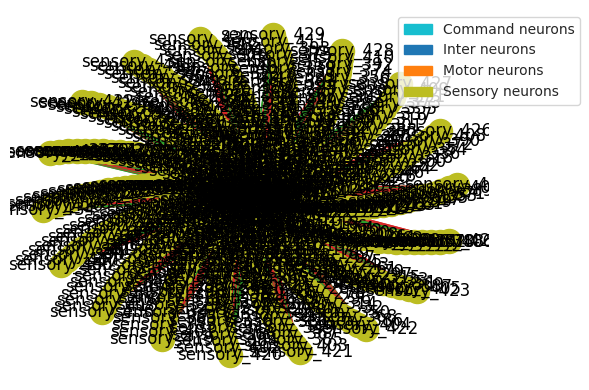

In [6]:


model = BinaryClassificationLTC(in_features,units=hidden_units, sparsity=sparsity)

criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

if from_checkpoint == True:

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    epoch_train_loss = checkpoint['train_losses']
    epoch_train_accuracy = checkpoint['train_accuracies']
    epoch_train_auc = checkpoint['train_aucs']
    epoch_train_f1 = checkpoint['train_f1s']
    epoch_val_loss = checkpoint['val_losses']
    epoch_val_accuracy = checkpoint['val_accuracies']
    epoch_val_auc = checkpoint['val_aucs']
    epoch_val_f1 = checkpoint['val_f1s']

else:
    epoch = 0 
    epoch_train_loss = []
    epoch_train_accuracy = []
    epoch_train_auc = []
    epoch_train_f1 = []
    epoch_val_loss = []
    epoch_val_accuracy = []
    epoch_val_auc = []
    epoch_val_f1 = []


model.to(device)


for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)




count_parameters(model)

model.print_model()
#model= nn.DataParallel(model,device_ids = [0, 1])
##################################################### Loss and Optimizer Settings #####################################################


#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)


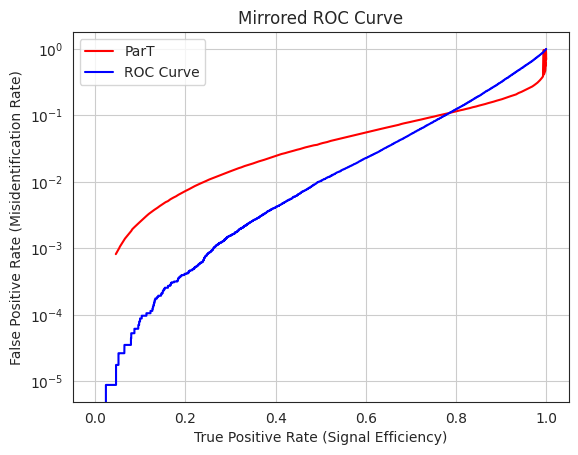

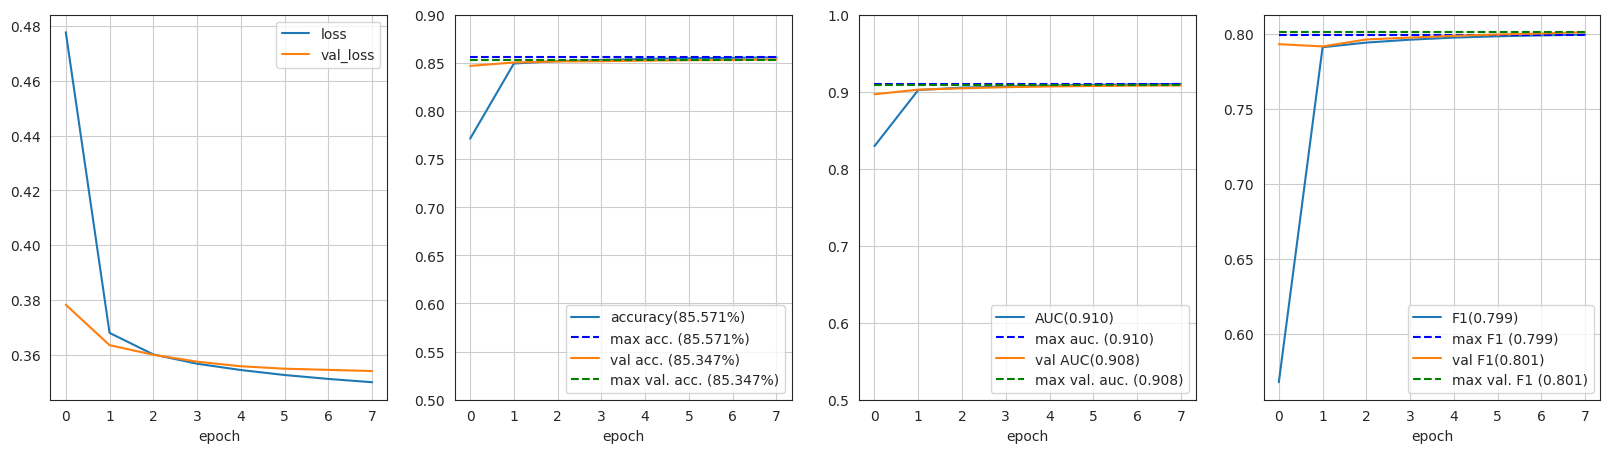

Training: Epoch [8/8] --- Loss: 0.3499 --- Accuracy: 0.8557 --- AUC: 0.910
Test    : Epoch [8/8] --- Loss: 0.3540 --- Accuracy: 0.8535 --- AUC: 0.908


In [7]:

acc_metric = BinaryAccuracy().to(device)
auc_metric = AUROC(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
roc_metric = BinaryROC().to('cpu')

model.to(device)


for i_epoch in range(n_epochs):

    train_losses = []
    train_accuracies = []
    train_aucs = []
    train_f1s =[]
    val_losses = []
    val_accuracies = []
    val_aucs = []
    val_f1s = []
   
    


    lr = optimizer.param_groups[0]['lr']
    print(f'Learning rate was set to {lr:.5f}.')

    model.train()
    for batch_particle_inputs, batch_labels in tqdm(train_dataloader): 

        particle_inputs = batch_particle_inputs.to(device)#.transpose(1,2)
        train_label = batch_labels.squeeze().to(device)
        
       
        optimizer.zero_grad()
        train_pred, _ = model(particle_inputs, states=None)
        train_pred = train_pred.squeeze()
      
        loss = criterion(train_pred, train_label)

        if not torch.isnan(loss):  
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())
        train_accuracy = acc_metric(train_pred, train_label)
        train_accuracies.append(train_accuracy.item())
        train_auc = auc_metric(train_pred, train_label)
        train_aucs.append(train_auc.item())
        train_f1 = f1_metric(train_pred, train_label)
        train_f1s.append(train_f1.item())

   
    
    #scheduler.step()

    print('Evaluating metrics...', end='\r')

    model.eval()
    with torch.no_grad():
        for val_particle_inputs, val_labels in test_dataloader: 

            val_particle_inputs = val_particle_inputs.to(device)#.transpose(1,2)
            val_labels = val_labels.squeeze().to(device)

            val_preds, _ = model(val_particle_inputs, states=None)
            val_preds = val_preds.squeeze()

            val_loss = criterion(val_preds, val_labels)   
            val_losses.append(val_loss.item())
            val_accuracy = acc_metric(val_preds, val_labels)
            val_accuracies.append(val_accuracy.item())
            val_auc = auc_metric(val_preds, val_labels)
            val_aucs.append(val_auc.item())
            val_f1 = f1_metric(val_preds,val_labels)
            val_f1s.append(val_f1.item())
           

            val_labels = val_labels.int()
            val_preds.cpu()
            fpr, tpr, _ = roc_metric(val_preds, val_labels)  
     
    plot_ROC(fpr.cpu().numpy(),tpr.cpu().numpy(),save_path=f'/home/asugu/work/part/roc_graphs/roc_{i_epoch+epoch}')

    epoch_val_loss.append(sum(val_losses) / len(val_losses))
    epoch_val_accuracy.append(sum(val_accuracies) / len(val_accuracies))
    epoch_val_auc.append(sum(val_aucs) / len(val_aucs))
    epoch_val_f1.append(sum(val_f1s) / len(val_f1s))
             
    epoch_train_loss.append( sum(train_losses) / len(train_losses))
    epoch_train_accuracy.append(sum(train_accuracies) / len(train_accuracies))
    epoch_train_auc.append(sum(train_aucs) / len(train_aucs))
    epoch_train_f1.append(sum(train_f1s) / len(train_f1s))
 
    plot_metrics(np.arange(i_epoch+epoch+1), epoch_train_loss, epoch_val_loss, epoch_train_accuracy, epoch_val_accuracy, epoch_train_auc, epoch_val_auc, epoch_train_f1, epoch_val_f1)

    print('Evaluating metrics finished!', end='\r')
    print(f'Training: Epoch [{i_epoch+epoch + 1}/{n_epochs+epoch}] --- Loss: {epoch_train_loss[-1]:.4f} --- Accuracy: {epoch_train_accuracy[-1]:.4f} --- AUC: {epoch_train_auc[-1]:.3f}\nTest    : Epoch [{i_epoch +epoch + 1}/{n_epochs+epoch}] --- Loss: {epoch_val_loss[-1]:.4f} --- Accuracy: {epoch_val_accuracy[-1]:.4f} --- AUC: {epoch_val_auc[-1]:.3f}\n', end='\r')
    

    torch.cuda.empty_cache()
    del loss, val_loss, train_pred, val_preds
    del train_losses, train_accuracies, train_aucs, train_f1s, val_losses, val_accuracies, val_aucs, val_f1s
    gc.collect()

    
#keys = ['train_losses', 'train_accuracies', 'train_aucs', 'val_losses', 'val_accuracies', 'val_aucs']
#values = [train_losses, train_accuracies, train_aucs, val_losses, val_accuracies, val_aucs]
#dict_metrics = {keys[i]: values[i] for i in range(len(keys))}

In [8]:
# Save model checkpoint
checkpoint = {
    'epoch': i_epoch + epoch + 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': epoch_train_loss,
    'train_accuracies': epoch_train_accuracy,
    'train_aucs': epoch_train_auc,
    'train_f1s': epoch_train_f1,
    'val_losses': epoch_val_loss,
    'val_accuracies': epoch_val_accuracy,
    'val_aucs': epoch_val_auc,
    'val_f1s': epoch_val_f1,

}

checkpoint_path = f'/home/asugu/work/part/LNN/checkpoints/model_checkpoint_hdf5_{i_epoch+epoch+1}.pth'
torch.save(checkpoint, checkpoint_path)

print(i_epoch+epoch+1)


8
